## CartPole Schaatsen

> **Probleem**: Als Peter wil ontsnappen aan de wolf, moet hij sneller kunnen bewegen dan de wolf. We zullen zien hoe Peter kan leren schaatsen, en specifiek hoe hij balans kan houden, met behulp van Q-Learning.

Laten we eerst de gym installeren en de benodigde bibliotheken importeren:


In [1]:
import sys
!pip install gym 

import gym
import matplotlib.pyplot as plt
import numpy as np
import random

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.7/bin/python3.7 -m pip install --upgrade pip' command.


## Maak een cartpole-omgeving


In [2]:
env = gym.make("CartPole-v1")
print(env.action_space)
print(env.observation_space)
print(env.action_space.sample())

Discrete(2)
Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
0


Om te zien hoe de omgeving werkt, laten we een korte simulatie uitvoeren van 100 stappen.


In [3]:
env.reset()

for i in range(100):
   env.render()
   env.step(env.action_space.sample())
env.close()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Tijdens de simulatie moeten we waarnemingen verkrijgen om te beslissen hoe te handelen. De `step`-functie geeft ons namelijk de huidige waarnemingen, de beloningsfunctie en de `done`-vlag terug, die aangeeft of het zinvol is om de simulatie voort te zetten of niet:


In [4]:
env.reset()

done = False
while not done:
   env.render()
   obs, rew, done, info = env.step(env.action_space.sample())
   print(f"{obs} -> {rew}")
env.close()

[ 0.03044442 -0.19543914 -0.04496216  0.28125618] -> 1.0
[ 0.02653564 -0.38989186 -0.03933704  0.55942606] -> 1.0
[ 0.0187378  -0.19424049 -0.02814852  0.25461393] -> 1.0
[ 0.01485299 -0.38894946 -0.02305624  0.53828712] -> 1.0
[ 0.007074   -0.19351108 -0.0122905   0.23842953] -> 1.0
[ 0.00320378  0.00178427 -0.00752191 -0.05810469] -> 1.0
[ 0.00323946  0.19701326 -0.008684   -0.35315131] -> 1.0
[ 0.00717973  0.00201587 -0.01574703 -0.06321931] -> 1.0
[ 0.00722005  0.19736001 -0.01701141 -0.36082863] -> 1.0
[ 0.01116725  0.39271958 -0.02422798 -0.65882671] -> 1.0
[ 0.01902164  0.19794307 -0.03740452 -0.37387001] -> 1.0
[ 0.0229805   0.39357584 -0.04488192 -0.67810827] -> 1.0
[ 0.03085202  0.58929164 -0.05844408 -0.98457719] -> 1.0
[ 0.04263785  0.78514572 -0.07813563 -1.2950295 ] -> 1.0
[ 0.05834076  0.98116859 -0.10403622 -1.61111521] -> 1.0
[ 0.07796413  0.78741784 -0.13625852 -1.35259196] -> 1.0
[ 0.09371249  0.98396202 -0.16331036 -1.68461179] -> 1.0
[ 0.11339173  0.79106371 -0.197

We kunnen de minimale en maximale waarde van die getallen krijgen:


In [5]:
print(env.observation_space.low)
print(env.observation_space.high)

[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]


In [6]:
def discretize(x):
    return tuple((x/np.array([0.25, 0.25, 0.01, 0.1])).astype(np.int))

Laten we ook een andere discretisatiemethode verkennen met behulp van bins:


In [7]:
def create_bins(i,num):
    return np.arange(num+1)*(i[1]-i[0])/num+i[0]

print("Sample bins for interval (-5,5) with 10 bins\n",create_bins((-5,5),10))

ints = [(-5,5),(-2,2),(-0.5,0.5),(-2,2)] # intervals of values for each parameter
nbins = [20,20,10,10] # number of bins for each parameter
bins = [create_bins(ints[i],nbins[i]) for i in range(4)]

def discretize_bins(x):
    return tuple(np.digitize(x[i],bins[i]) for i in range(4))

Sample bins for interval (-5,5) with 10 bins
 [-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]


Laten we nu een korte simulatie uitvoeren en die discrete omgevingswaarden observeren.


In [8]:
env.reset()

done = False
while not done:
   #env.render()
   obs, rew, done, info = env.step(env.action_space.sample())
   #print(discretize_bins(obs))
   print(discretize(obs))
env.close()

(0, 0, -1, -3)
(0, 0, -2, 0)
(0, 0, -2, -3)
(0, 1, -3, -6)
(0, 2, -4, -9)
(0, 3, -6, -12)
(0, 2, -8, -9)
(0, 3, -10, -13)
(0, 4, -13, -16)
(0, 4, -16, -19)
(0, 4, -20, -17)
(0, 4, -24, -20)


## Q-Tabel Structuur


In [9]:
Q = {}
actions = (0,1)

def qvalues(state):
    return [Q.get((state,a),0) for a in actions]

In [10]:
# hyperparameters
alpha = 0.3
gamma = 0.9
epsilon = 0.90

In [11]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

Qmax = 0
cum_rewards = []
rewards = []
for epoch in range(100000):
    obs = env.reset()
    done = False
    cum_reward=0
    # == do the simulation ==
    while not done:
        s = discretize(obs)
        if random.random()<epsilon:
            # exploitation - chose the action according to Q-Table probabilities
            v = probs(np.array(qvalues(s)))
            a = random.choices(actions,weights=v)[0]
        else:
            # exploration - randomly chose the action
            a = np.random.randint(env.action_space.n)

        obs, rew, done, info = env.step(a)
        cum_reward+=rew
        ns = discretize(obs)
        Q[(s,a)] = (1 - alpha) * Q.get((s,a),0) + alpha * (rew + gamma * max(qvalues(ns)))
    cum_rewards.append(cum_reward)
    rewards.append(cum_reward)
    # == Periodically print results and calculate average reward ==
    if epoch%5000==0:
        print(f"{epoch}: {np.average(cum_rewards)}, alpha={alpha}, epsilon={epsilon}")
        if np.average(cum_rewards) > Qmax:
            Qmax = np.average(cum_rewards)
            Qbest = Q
        cum_rewards=[]

0: 108.0, alpha=0.3, epsilon=0.9


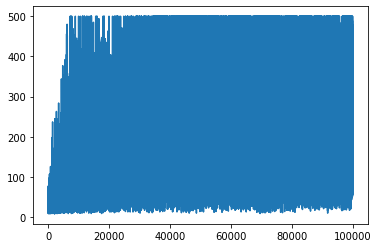

In [20]:
plt.plot(rewards)

Van deze grafiek is het niet mogelijk iets af te leiden, omdat door de aard van het stochastische trainingsproces de lengte van trainingssessies sterk varieert. Om meer inzicht te krijgen in deze grafiek, kunnen we het **lopende gemiddelde** berekenen over een reeks experimenten, laten we zeggen 100. Dit kan eenvoudig worden gedaan met `np.convolve`:


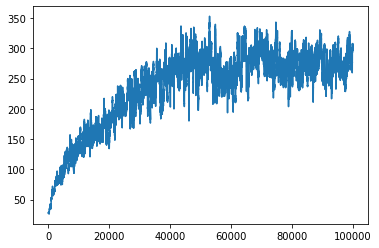

In [22]:
def running_average(x,window):
    return np.convolve(x,np.ones(window)/window,mode='valid')

plt.plot(running_average(rewards,100))

## Variëren van hyperparameters en het resultaat in actie zien

Nu zou het interessant zijn om daadwerkelijk te zien hoe het getrainde model zich gedraagt. Laten we de simulatie uitvoeren, waarbij we dezelfde strategie voor actieselectie volgen als tijdens de training: sampling op basis van de waarschijnlijkheidsverdeling in de Q-Table:


In [23]:
obs = env.reset()
done = False
while not done:
   s = discretize(obs)
   env.render()
   v = probs(np.array(qvalues(s)))
   a = random.choices(actions,weights=v)[0]
   obs,_,done,_ = env.step(a)
env.close()

## Resultaat opslaan als een geanimeerde GIF

Als je indruk wilt maken op je vrienden, kun je ze de geanimeerde GIF van de balancerende stok sturen. Om dit te doen, kunnen we `env.render` aanroepen om een afbeeldingsframe te genereren en deze vervolgens opslaan als een geanimeerde GIF met behulp van de PIL-bibliotheek:


In [26]:
from PIL import Image
obs = env.reset()
done = False
i=0
ims = []
while not done:
   s = discretize(obs)
   img=env.render(mode='rgb_array')
   ims.append(Image.fromarray(img))
   v = probs(np.array([Qbest.get((s,a),0) for a in actions]))
   a = random.choices(actions,weights=v)[0]
   obs,_,done,_ = env.step(a)
   i+=1
env.close()
ims[0].save('images/cartpole-balance.gif',save_all=True,append_images=ims[1::2],loop=0,duration=5)
print(i)

360



---

**Disclaimer**:  
Dit document is vertaald met behulp van de AI-vertalingsservice [Co-op Translator](https://github.com/Azure/co-op-translator). Hoewel we streven naar nauwkeurigheid, willen we u erop wijzen dat geautomatiseerde vertalingen fouten of onnauwkeurigheden kunnen bevatten. Het originele document in de oorspronkelijke taal moet worden beschouwd als de gezaghebbende bron. Voor kritieke informatie wordt professionele menselijke vertaling aanbevolen. Wij zijn niet aansprakelijk voor misverstanden of verkeerde interpretaties die voortvloeien uit het gebruik van deze vertaling.
